# Linear Classifiers

run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [3]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

In [5]:
if torch.cuda.is_available:
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


In this notebook we will use the **bias trick**: By adding an extra constant feature of ones to each image, we avoid the need to keep track of a bias vector; the bias will be encoded as the part of the weight matrix that interacts with the constant ones in the input.

## Load the CIFAR-10 dataset

The utility function `preprocess_cifar10()` in the `linear_classifier.py` returns the entire CIFAR-10 dataset as a set of six **Torch tensors**:

- `X_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `X_val` contains all validation images
- `y_val` contains all validation labels
- `X_test` contains all test images
- `y_test` contains all test labels

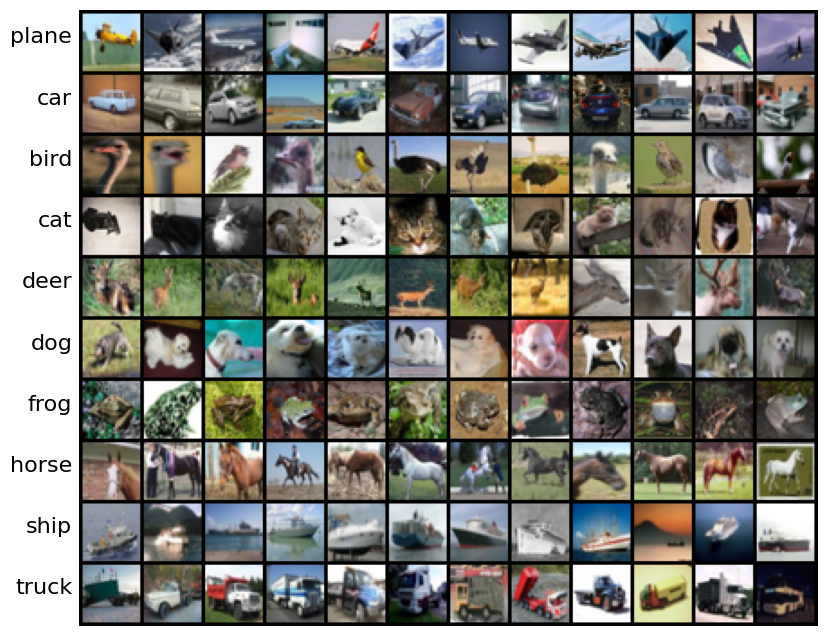

Train data shape:  torch.Size([40000, 3073])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3073])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3073])
Test labels shape:  torch.Size([10000])


In [8]:
from linear_classifier import preprocess_cifar10

data_dict = preprocess_cifar10(bias_trick=True, cuda=True, dtype=torch.float64)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

## SVM Classifier

the naive version of svm loss (function `svm_loss_naive` in the file `linear_classifier.py` )

use **numeric gradient checking**: we will use a finite differences approach to numerically estimate the gradient of the forward pass, and compare this numeric gradient to the analytic gradient

In [9]:
from linear_classifier import svm_loss_naive,grad_check_sparse

# Use a random W and a minibatch of data from the val set for gradient checking
# For numeric gradient checking it is a good idea to use 64-bit floating point
# numbers for increased numeric precision; however when actually training models
# we usually use 32-bit floating point numbers for increased speed.
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
batch_size = 64
X_batch = data_dict['X_val'][:batch_size]
y_batch = data_dict['y_val'][:batch_size]

# Compute the loss and its gradient at W.
_, grad = svm_loss_naive(W, X_batch, y_batch, reg=0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should
# match almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_batch, y_batch, reg=0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -0.048114 analytic: -0.048114, relative error: 3.295112e-07
numerical: 0.018976 analytic: 0.018976, relative error: 4.874036e-08
numerical: -0.018151 analytic: -0.018151, relative error: 1.157360e-08
numerical: 0.023053 analytic: 0.023053, relative error: 2.638321e-07
numerical: -0.432468 analytic: -0.432468, relative error: 7.750194e-09
numerical: -0.077213 analytic: -0.077213, relative error: 2.663610e-08
numerical: -0.062877 analytic: -0.062877, relative error: 1.890412e-07
numerical: 0.067642 analytic: 0.067642, relative error: 2.798865e-08
numerical: 0.082919 analytic: 0.082919, relative error: 3.085769e-07
numerical: -0.005404 analytic: -0.005404, relative error: 4.617241e-08


gradient check with regularization turned on

In [10]:
from linear_classifier import svm_loss_naive,grad_check_sparse

W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
batch_size = 64
X_batch = data_dict['X_val'][:batch_size]
y_batch = data_dict['y_val'][:batch_size]

# Compute the loss and its gradient at W.
_, grad = svm_loss_naive(W, X_batch, y_batch, reg=1e3) 

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should
# match almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_batch, y_batch, reg=1e3)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 0.031013 analytic: 0.031013, relative error: 1.927325e-08
numerical: 0.120390 analytic: 0.120390, relative error: 2.594178e-08
numerical: 0.024855 analytic: 0.024855, relative error: 6.807738e-08
numerical: -0.625890 analytic: -0.625890, relative error: 1.655344e-08
numerical: -0.073908 analytic: -0.073908, relative error: 5.325767e-08
numerical: 0.201004 analytic: 0.201004, relative error: 4.648653e-08
numerical: 0.273761 analytic: 0.273761, relative error: 4.369234e-08
numerical: 0.210494 analytic: 0.210494, relative error: 3.275693e-11
numerical: -0.209039 analytic: -0.209039, relative error: 1.468299e-08
numerical: -0.004307 analytic: -0.004307, relative error: 3.733316e-07


the vectorized version of SVM ( function `svm_loss_vectorized` in the file  `linear_classifier.py` ) 

In [16]:
from linear_classifier import svm_loss_naive, svm_loss_vectorized

W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]
reg = 0.000005

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_batch, y_batch, reg)

torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('Naive loss: %e computed in %.2fms' % (loss_naive, ms_naive))

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
loss_vec, _ = svm_loss_vectorized(W, X_batch, y_batch, reg)

torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('Vectorized loss: %e computed in %.2fms' % (loss_vec, ms_vec))

# The losses should match but the vectorized implementation should be much faster.
print('Difference: %.2e' % (loss_naive - loss_vec))
print('Speedup: %.2fX' % (ms_naive / ms_vec))

Naive loss: 8.996804e+00 computed in 260.08ms
Vectorized loss: 8.996804e+00 computed in 2.51ms
Difference: 8.88e-15
Speedup: 103.79X


In [19]:
from linear_classifier import svm_loss_naive, svm_loss_vectorized

W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]
reg = 0.000005

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_batch, y_batch, 0.000005)

torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('Naive loss and gradient: computed in %.2fms' % ms_naive)

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
_, grad_vec = svm_loss_vectorized(W, X_batch, y_batch, 0.000005)

torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('Vectorized loss and gradient: computed in %.2fms' % ms_vec)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a tensor, so
# we use the Frobenius norm to compare them.
grad_difference = torch.norm(grad_naive - grad_vec, p='fro')
print('Gradient difference: %.2e' % grad_difference)
print('Speedup: %.2fX' % (ms_naive / ms_vec))

Naive loss and gradient: computed in 274.73ms
Vectorized loss and gradient: computed in 1.87ms
Gradient difference: 1.87e-14
Speedup: 146.75X


implement a training pipeline for linear classifiers (function `train_linear_classifier` in the file `linear_classifer.py`)

In [20]:
from linear_classifier import svm_loss_vectorized, train_linear_classifier

torch.cuda.synchronize()
tic = time.time()

W, loss_hist = train_linear_classifier(svm_loss_vectorized, None, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=3e-11, reg=2.5e4,
                                       num_iters=1500, verbose=True)

torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 9.000775
iteration 100 / 1500: loss 9.000781
iteration 200 / 1500: loss 9.000786
iteration 300 / 1500: loss 9.000775
iteration 400 / 1500: loss 9.000772
iteration 500 / 1500: loss 9.000779
iteration 600 / 1500: loss 9.000769
iteration 700 / 1500: loss 9.000794
iteration 800 / 1500: loss 9.000766
iteration 900 / 1500: loss 9.000752
iteration 1000 / 1500: loss 9.000765
iteration 1100 / 1500: loss 9.000772
iteration 1200 / 1500: loss 9.000771
iteration 1300 / 1500: loss 9.000766
iteration 1400 / 1500: loss 9.000775
That took 1.476553s


A useful debugging strategy is to plot the loss as a function of iteration number

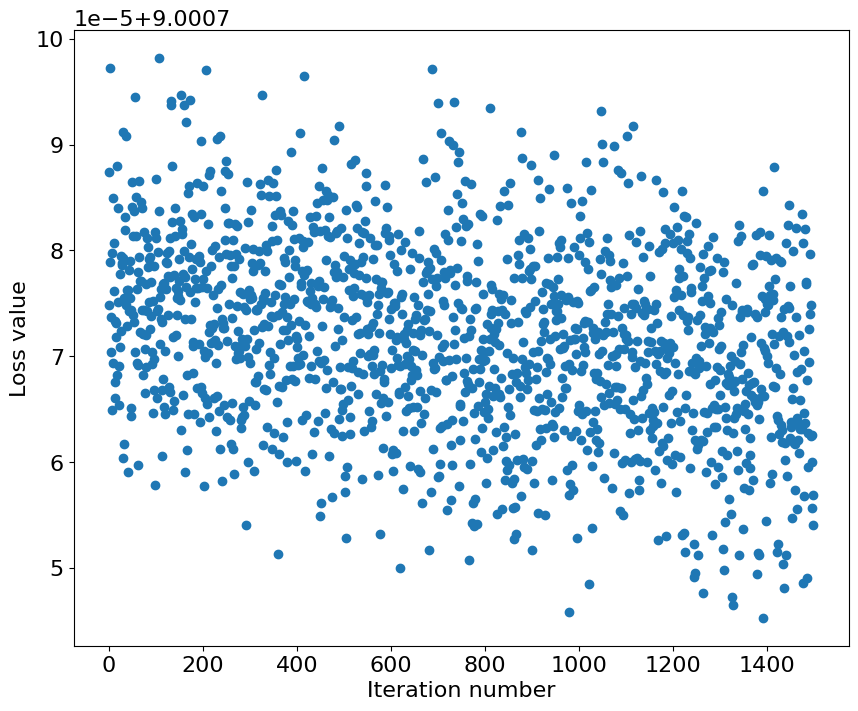

In [23]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

evaluate the performance our trained model on both the training and validation set (function `predict_linear_classifier` in the file `linear_classifier.py` )

In [25]:
from linear_classifier import predict_linear_classifier

y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).double().mean().item()
print('Training accuracy: %.2f%%' % train_acc)

y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).double().mean().item()
print('Validation accuracy: %.2f%%' % val_acc)

Training accuracy: 9.06%
Validation accuracy: 8.85%


the performance of our initial model is quite bad. To find a better hyperparamters, we first modulized the functions  LinearSVM (class `LinearSVM` in `linear_classifier.py` )

use the validation set to tune hyperparameters (regularization strength and learning rate)

In [30]:
import os
from linear_classifier import LinearSVM, svm_get_search_params, test_one_param_set

learning_rates, regularization_strengths = svm_get_search_params()
num_models = len(learning_rates) * len(regularization_strengths)

i = 0
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (train_acc, val_acc). 
results = {}
best_val = -1.0   # The highest validation accuracy that we have seen so far.
best_svm_model = None # The LinearSVM object that achieved the highest validation rate.
num_iters = 2000 # number of iterations

for lr in learning_rates:
  for reg in regularization_strengths:
    i += 1
    print('Training SVM %d / %d with learning_rate=%e and reg=%e'
          % (i, num_models, lr, reg))
    
    cand_svm_model, cand_train_acc, cand_val_acc = test_one_param_set(LinearSVM(), data_dict, lr, reg, num_iters)

    if cand_val_acc > best_val:
        best_val = cand_val_acc
        best_svm_model = cand_svm_model # save the svm
    results[(lr, reg)] = (cand_train_acc, cand_val_acc)


# Print out results.
for lr, reg in sorted(results):
  train_acc, val_acc = results[(lr, reg)]
  print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
         lr, reg, train_acc, val_acc))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# save the best model
path = os.path.join('../models','svm_best_model.pt')
best_svm_model.save(path)

Training SVM 1 / 12 with learning_rate=1.000000e-03 and reg=1.000000e-02
Training SVM 2 / 12 with learning_rate=1.000000e-03 and reg=1.000000e-01
Training SVM 3 / 12 with learning_rate=1.000000e-03 and reg=5.000000e-01
Training SVM 4 / 12 with learning_rate=7.000000e-03 and reg=1.000000e-02
Training SVM 5 / 12 with learning_rate=7.000000e-03 and reg=1.000000e-01
Training SVM 6 / 12 with learning_rate=7.000000e-03 and reg=5.000000e-01
Training SVM 7 / 12 with learning_rate=5.000000e-03 and reg=1.000000e-02
Training SVM 8 / 12 with learning_rate=5.000000e-03 and reg=1.000000e-01
Training SVM 9 / 12 with learning_rate=5.000000e-03 and reg=5.000000e-01
Training SVM 10 / 12 with learning_rate=1.000000e-02 and reg=1.000000e-02
Training SVM 11 / 12 with learning_rate=1.000000e-02 and reg=1.000000e-01
Training SVM 12 / 12 with learning_rate=1.000000e-02 and reg=5.000000e-01
lr 1.000000e-03 reg 1.000000e-02 train accuracy: 38.850000 val accuracy: 37.480000
lr 1.000000e-03 reg 1.000000e-01 train

Visualize the cross-validation results

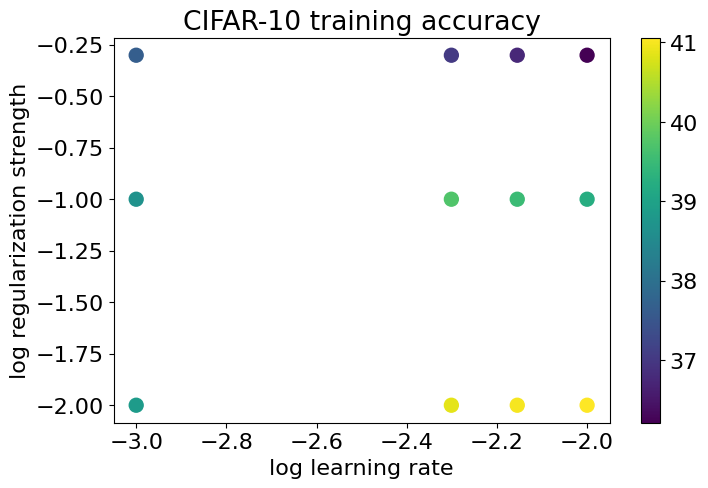

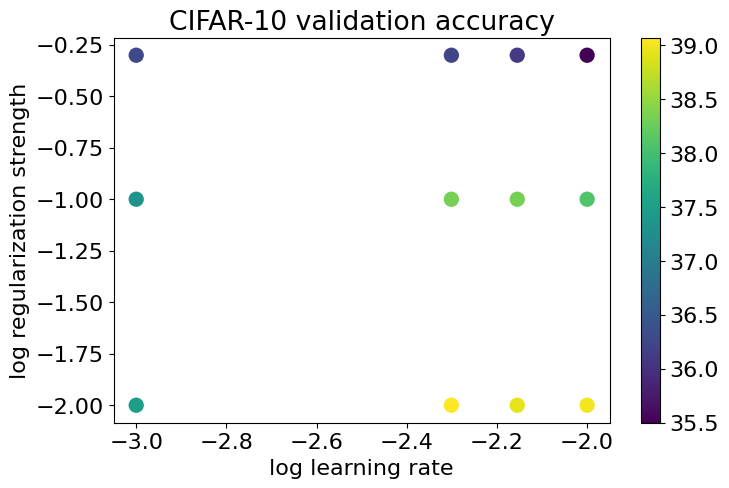

In [32]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

Evaluate the best svm on test set

In [33]:
y_test_pred = best_svm_model.predict(data_dict['X_test'])
test_accuracy = torch.mean((data_dict['y_test'] == y_test_pred).double())
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.393900


Visualize the learned weights for each class

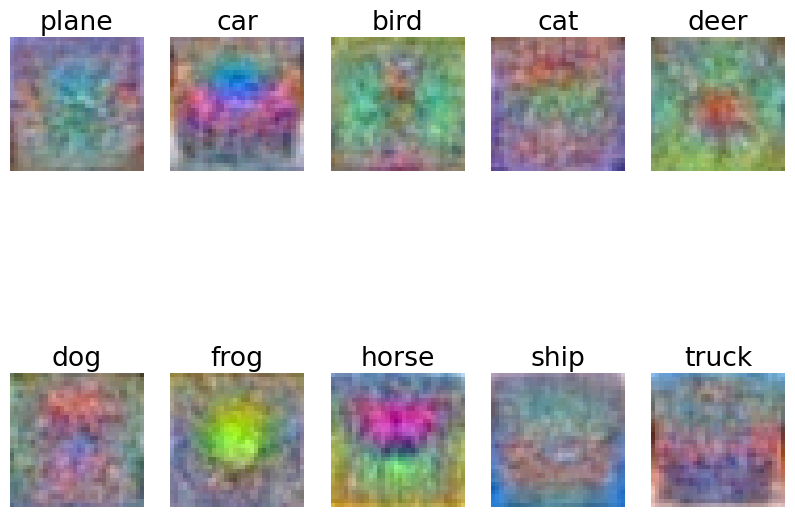

In [34]:
w = best_svm_model.W[:-1,:] # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.type(torch.uint8).cpu())
    plt.axis('off')
    plt.title(classes[i])

## Softmax Classifier

the naive softmax loss function with nested loops (function `softmax_loss_naive` in the file `linear_classifier.py` )

As a sanity check to see whether we have implemented the loss correctly, run the softmax classifier with a small random weight matrix and no regularization. We should see loss near log(10) = 2.3

In [36]:
from linear_classifier import softmax_loss_naive

# Generate a random softmax weight tensor and use it to compute the loss.
W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

loss, _ = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

# As a rough sanity check, our loss should be something close to log(10.0).
print('loss: %f' % loss)
print('sanity check: %f' % (math.log(10.0)))

loss: 2.302709
sanity check: 2.302585


use gradient checking to debug the analytic gradient of our naive softmax loss function

In [37]:
from linear_classifier import softmax_loss_naive

W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

_, grad = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg=0.0)[0]
grad_check_sparse(f, W, grad, 10)

numerical: 0.003022 analytic: 0.003022, relative error: 8.588150e-07
numerical: 0.006332 analytic: 0.006332, relative error: 6.092972e-08
numerical: 0.005365 analytic: 0.005365, relative error: 2.442867e-08
numerical: 0.002571 analytic: 0.002571, relative error: 6.757873e-07
numerical: 0.007502 analytic: 0.007502, relative error: 5.640392e-08
numerical: 0.006415 analytic: 0.006415, relative error: 8.408205e-08
numerical: 0.011393 analytic: 0.011393, relative error: 1.023038e-07
numerical: 0.001828 analytic: 0.001828, relative error: 5.153998e-07
numerical: -0.014702 analytic: -0.014702, relative error: 6.512029e-08
numerical: -0.005192 analytic: -0.005192, relative error: 7.500315e-07


perform another gradient check with regularization enabled

In [38]:
from linear_classifier import softmax_loss_naive

W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
reg = 10.0

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

_, grad = softmax_loss_naive(W, X_batch, y_batch, reg)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg)[0]
grad_check_sparse(f, W, grad, 10)

numerical: 0.016856 analytic: 0.016856, relative error: 2.568229e-08
numerical: 0.004752 analytic: 0.004752, relative error: 1.358478e-06
numerical: -0.003034 analytic: -0.003034, relative error: 2.222917e-07
numerical: -0.007409 analytic: -0.007409, relative error: 3.078334e-07
numerical: 0.009568 analytic: 0.009568, relative error: 1.223351e-07
numerical: -0.006931 analytic: -0.006931, relative error: 8.145284e-08
numerical: -0.012325 analytic: -0.012325, relative error: 3.078811e-07
numerical: 0.012053 analytic: 0.012053, relative error: 1.339277e-07
numerical: 0.007550 analytic: 0.007550, relative error: 8.491310e-08
numerical: 0.018216 analytic: 0.018216, relative error: 2.216731e-07


the vectorized form (function `softmax_loss_vectorized` in the file `linear_classifier.py`)

In [42]:
from linear_classifier import softmax_loss_naive, softmax_loss_vectorized

W = 0.0001 * torch.randn(3073, 10, dtype=data_dict['X_val'].dtype, device=data_dict['X_val'].device)
reg = 0.05

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('naive loss: %e computed in %fs' % (loss_naive, ms_naive))

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
loss_vec, grad_vec = softmax_loss_vectorized(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('vectorized loss: %e computed in %fs' % (loss_vec, ms_vec))

# we use the Frobenius norm to compare the two versions of the gradient.
loss_diff = (loss_naive - loss_vec).abs().item()
grad_diff = torch.norm(grad_naive - grad_vec, p='fro')
print('Loss difference: %.2e' % loss_diff)
print('Gradient difference: %.2e' % grad_diff)
print('Speedup: %.2fX' % (ms_naive / ms_vec))

naive loss: 2.302282e+00 computed in 307.967901s
vectorized loss: 2.302282e+00 computed in 2.068996s
Loss difference: 4.44e-16
Gradient difference: 2.94e-16
Speedup: 148.85X


train a softmax classifier with some default hyperparameters

In [43]:
from linear_classifier import softmax_loss_vectorized

torch.cuda.synchronize()
tic = time.time()

W, loss_hist = train_linear_classifier(softmax_loss_vectorized, None, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-10, reg=2.5e4,
                                       num_iters=1500, verbose=True)

torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 2.303360
iteration 100 / 1500: loss 2.303362
iteration 200 / 1500: loss 2.303359
iteration 300 / 1500: loss 2.303360
iteration 400 / 1500: loss 2.303358
iteration 500 / 1500: loss 2.303358
iteration 600 / 1500: loss 2.303358
iteration 700 / 1500: loss 2.303357
iteration 800 / 1500: loss 2.303356
iteration 900 / 1500: loss 2.303356
iteration 1000 / 1500: loss 2.303353
iteration 1100 / 1500: loss 2.303353
iteration 1200 / 1500: loss 2.303352
iteration 1300 / 1500: loss 2.303353
iteration 1400 / 1500: loss 2.303351
That took 1.753179s


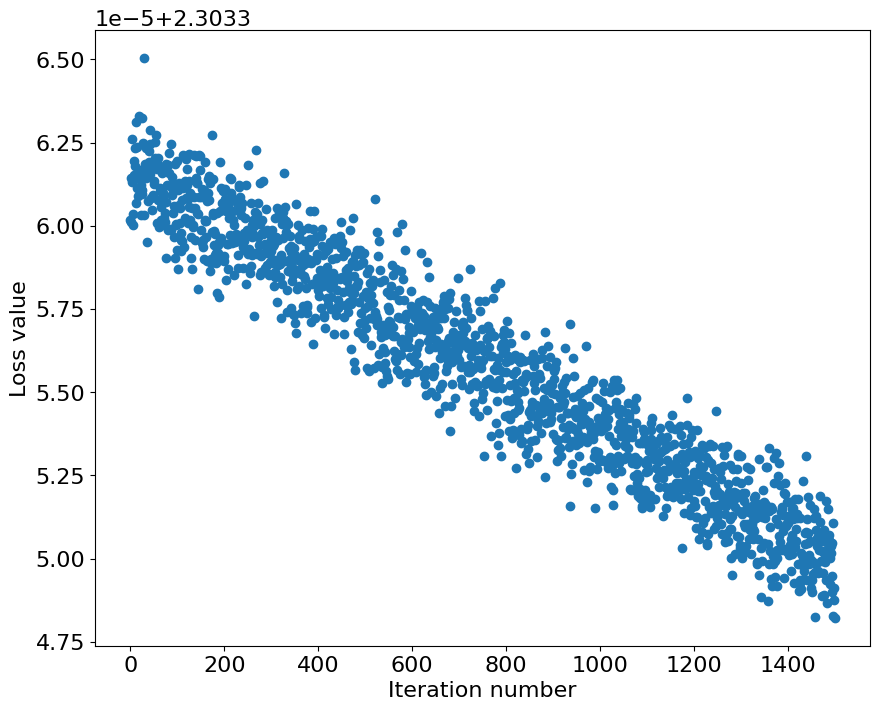

In [44]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

compute the accuracy of current model

In [47]:
from linear_classifier import predict_linear_classifier

# evaluate the performance on both the training and validation set
y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).double().mean().item()
print('training accuracy: %.2f%%' % train_acc)
y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).double().mean().item()
print('validation accuracy: %.2f%%' % val_acc)

training accuracy: 10.63%
validation accuracy: 10.34%


use the validation set to tune hyperparameters (regularization strength and learning rate)

In [48]:
import os
from linear_classifier import Softmax, softmax_get_search_params, test_one_param_set

learning_rates, regularization_strengths = softmax_get_search_params()
num_models = len(learning_rates) * len(regularization_strengths)

i = 0
# As before, store your cross-validation results in this dictionary.
# The keys should be tuples of (learning_rate, regularization_strength) and
# the values should be tuples (train_acc, val_acc)
results = {}
best_val = -1.0   # The highest validation accuracy that we have seen so far.
best_softmax_model = None # The Softmax object that achieved the highest validation rate.
num_iters = 2000 # number of iterations

for lr in learning_rates:
  for reg in regularization_strengths:
    i += 1
    print('Training Softmax %d / %d with learning_rate=%e and reg=%e'
          % (i, num_models, lr, reg))

    cand_softmax_model, cand_train_acc, cand_val_acc = test_one_param_set(Softmax(), data_dict, lr, reg, num_iters)

    if cand_val_acc > best_val:
      best_val = cand_val_acc
      best_softmax_model = cand_softmax_model # save the classifier
    results[(lr, reg)] = (cand_train_acc, cand_val_acc)

# Print out results.
for lr, reg in sorted(results):
  train_acc, val_acc = results[(lr, reg)]
  print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
         lr, reg, train_acc, val_acc))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# save the best model
path = os.path.join('../models','softmax_best_model.pt')
best_softmax_model.save(path)

Training Softmax 1 / 8 with learning_rate=1.000000e-02 and reg=1.000000e-02
Training Softmax 2 / 8 with learning_rate=1.000000e-02 and reg=5.000000e-02
Training Softmax 3 / 8 with learning_rate=5.000000e-02 and reg=1.000000e-02
Training Softmax 4 / 8 with learning_rate=5.000000e-02 and reg=5.000000e-02
Training Softmax 5 / 8 with learning_rate=7.000000e-02 and reg=1.000000e-02
Training Softmax 6 / 8 with learning_rate=7.000000e-02 and reg=5.000000e-02
Training Softmax 7 / 8 with learning_rate=1.000000e-01 and reg=1.000000e-02
Training Softmax 8 / 8 with learning_rate=1.000000e-01 and reg=5.000000e-02
lr 1.000000e-02 reg 1.000000e-02 train accuracy: 40.365000 val accuracy: 38.550000
lr 1.000000e-02 reg 5.000000e-02 train accuracy: 38.750000 val accuracy: 37.300000
lr 5.000000e-02 reg 1.000000e-02 train accuracy: 41.437500 val accuracy: 39.660000
lr 5.000000e-02 reg 5.000000e-02 train accuracy: 38.502500 val accuracy: 37.140000
lr 7.000000e-02 reg 1.000000e-02 train accuracy: 41.310000 v

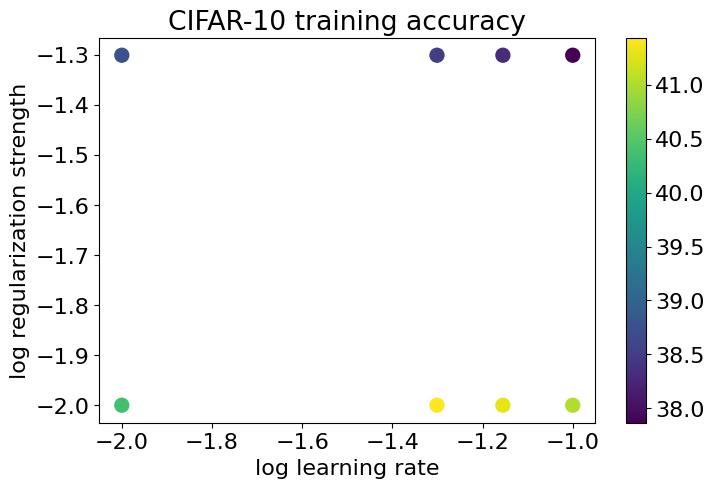

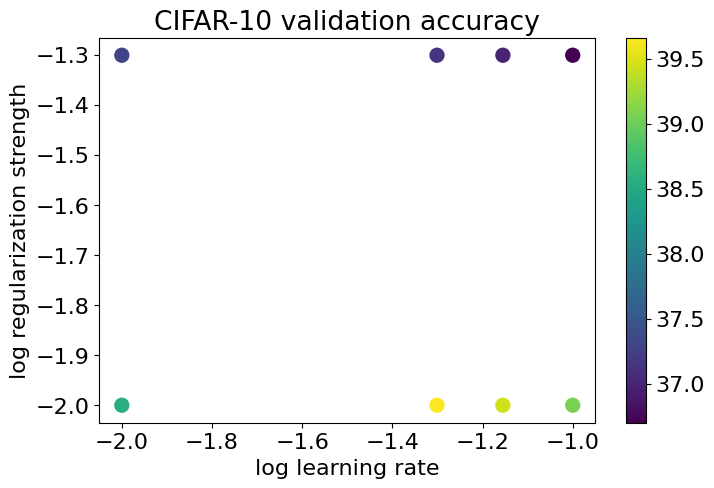

In [49]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

evaluate the performance of your best model on test set

In [50]:
y_test_pred = best_softmax_model.predict(data_dict['X_test'])
test_accuracy = torch.mean((data_dict['y_test'] == y_test_pred).double())
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.400500


visualize the learned weights for each class

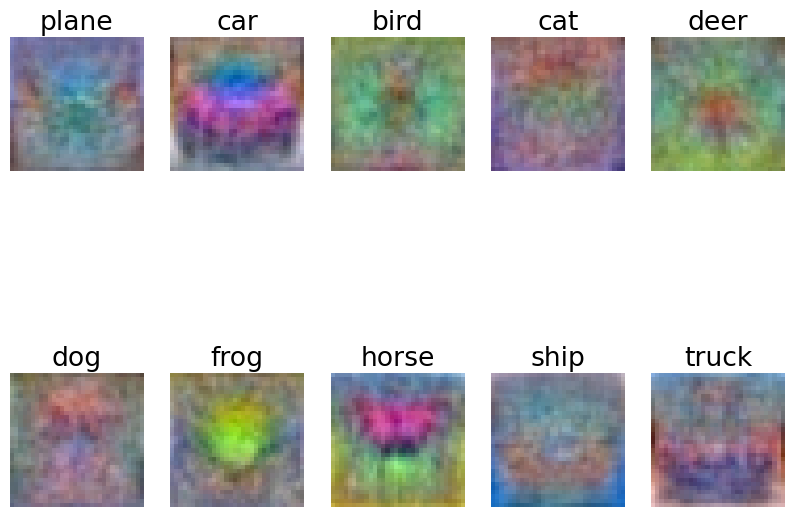

In [51]:
w = best_softmax_model.W[:-1,:] # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.type(torch.uint8).cpu())
  plt.axis('off')
  plt.title(classes[i])